# Neural de Bruijn Graph (nDBG)

This notebook shows how to use an artificial neural network for re-constructing sequence from corrupted fragments.  When the fragmented sequences are noisy, the extracted k-mer will contain many errors. If we use those corrupted k-mer for construct a de Bruijn graph, the graph will be too complicated to be resolved to a single path. When the reads are nosiy and short, we demostrate that it is possible to use a simple multi-layer perceptron network to predict the (k+1)th base from noisy k-mer and we can use it to construct the assembly path.

First, we need some boilerplate code to load the PyTorch and other modules 

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import os
import random
torch.manual_seed(42)
random.seed(42)

In [2]:
from IPython.display import SVG

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

Here we define the simple NerualDBG class as subclass of `torch.nn.Module`. The defined model is relatively trivial. It is just a three layer of full connected linear layers with ReLU activation function.

In [4]:
class NeuralDBG(nn.Module):

    def __init__(self, input_k, hidden1, hidden2, hidden3):
        super(NeuralDBG, self).__init__()
        self.linear1 = nn.Linear(input_k * 4, hidden1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden2, hidden3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden3, 4)
        nn.init.xavier_uniform(self.linear1.weight)
        nn.init.xavier_uniform(self.linear2.weight)
        nn.init.xavier_uniform(self.linear3.weight)
        nn.init.xavier_uniform(self.linear4.weight)

        self.input_k = input_k
        

    def forward(self, seq_t):
        """ seq_t: 4 by k concatenated one-hot encoded vector """
        h1 = self.relu1(self.linear1(seq_t.view(-1, self.input_k*4)))
        h2 = self.relu2(self.linear2((h1)))
        h3 = self.relu3(self.linear3((h2)))

        out = self.linear4(h3)
        #print(out)
        return out


We define a couple utility functions for encoding DNA bases to vectors and simulate sequencing errors.

In [5]:

torch.set_default_tensor_type('torch.cuda.FloatTensor')

bmap = {"A":0, "C":1, "G":2, "T":3}
def one_hot(b):
    t = [[0,0,0,0]]
    i = bmap[b]
    t[0][i] = 1
    return t

print("one-hot encoding for DNA bases")
print("A:", one_hot("A"))
print("C:", one_hot("C"))
print("G:", one_hot("G"))
print("T:", one_hot("T"))


one-hot encoding for DNA bases
A: [[1, 0, 0, 0]]
C: [[0, 1, 0, 0]]
G: [[0, 0, 1, 0]]
T: [[0, 0, 0, 1]]


In [6]:
def sim_error(seq, pi=0.05, pd=0.05, ps=0.01):
    """
    Given an input sequence `seq`, generating another
    sequence with errors. 
    pi: insertion error rate
    pd: deletion error rate
    ps: substitution error rate
    """
    out_seq = []
    for c in seq:
        while 1:
            r = random.uniform(0,1)
            if r < pi:
                out_seq.append(random.choice(["A","C","G","T"]))
            else:
                break
        r -= pi
        if r < pd:
            continue
        r -= pd
        if r < ps:
            out_seq.append(random.choice(["A","C","G","T"]))
            continue
        out_seq.append(c)
    return "".join(out_seq)

In [7]:
def quick_dot(seq1, seq2, k=8):
    kmer_map = {}
    kmer_size = k
    for i in range(len(seq1)-kmer_size):
        kmer = seq1[i:i+kmer_size]
        kmer_map.setdefault(kmer,[[],[]])
        kmer_map[kmer][0].append(i)
    for i in range(len(seq2)-kmer_size):
        kmer = seq2[i:i+kmer_size]
        kmer_map.setdefault(kmer,[[],[]])
        kmer_map[kmer][1].append(i)
    xary = []
    yary = []
    for kmer in kmer_map:
        km = kmer_map[kmer]
        if len(km[0]) * len(km[1]) == 0:
            continue
        for x in km[0]:
            for y in km[1]:
                xary.append(x)
                yary.append(y)
    xary = np.array(xary)
    yary = np.array(yary)
    plt.figure(figsize=(6,6))
    plt.plot(xary, yary,".")
    maxx = max(len(seq1), len(seq2))
    maxy = maxx
    plt.xlim(0, maxx)
    plt.ylim(0, maxy)
    
def plot_kmer_hist(seqs):
    kmer_map = {}
    for s in seqs:
        for i in range(len(s)-kmer_size):
            kmer = s[i:i+kmer_size]
            kmer_map[kmer] = kmer_map.get(kmer, 0) + 1
    data = kmer_map.values()
    plt.hist(data,bins=50, range=(0,50))

Some globale parameters. `kmer_size`: the size of kmer used. `seq_len`: the length of a small sequence that we try to assemble from noisy smaller fragments.

In [8]:
kmer_size = 10
seq_len = 500

Generate a random sequence of length `seq_len` as our original teamplate sequences.

In [9]:
seq = [random.choice(["A","C","G","T"]) for _ in range(seq_len)]
print("".join(seq))
# convert the `seq` to a PyTorch tensor

AAGCCCAATAAACCACTCTGACTGGCCGAATAGGGATATAGGCAACGACATGTGCGGCGACCCTTGCGACAGTGACGCTTTCGCCGTTGCCTAAACCTATTTGAAGGAGTCTAGCAGCCGCAGTAAGGCACAATACCTCGTCCGTGTTACCAGACCAAACAAGACGTCCTCTTCAATGTTTAAATGACCCTCTCGTCATAAAACCTTTCTACTATGTGTTCCGCAAGAATCAACAACTACAATGGCGCGTCGTGAATAACGCGACGGCTGAGACGAACGGCGCGTGAATGAAGCGCTTAAACAGCTCAGGAGCCAGTCCCCTACGTCGCATATCCTGGCCACTGGAGGTGAAGCGAATGGTATCGATACGTAGGAGGTGTGCCTTCGTAGGCTGTTTCTCAGGACGCCCAACTATTCTTTCCAATCCTACATCTGTTTCTTGCGTCGTAGCGGGACCCTCCATTGTTACTTATTAGGTTCTCGTTATGTCTCATAATCTC


Just show a quick dot plot of the template sequence against itself. If there is no off-diagonal dot, there is on identical k-mer of size `kmer_size`.  In such case, we should be able to reconstruct the full sequence without any ambiguity. 

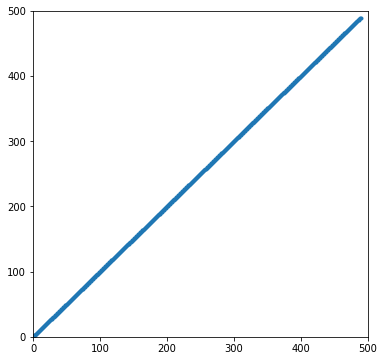

In [10]:
quick_dot("".join(seq), "".join(seq), k = kmer_size)

Convert the template to a Torch tensor.

In [11]:
tmp = []
for i in range(len(seq)-kmer_size-1):
    tmp.append( ([one_hot(c) for c in seq[i:i+kmer_size]], [one_hot(c) for c in seq[i+kmer_size]]) )
seq_in_, seq_out_ = zip(*tmp)
seq_in_ = Variable(torch.FloatTensor(np.array(seq_in_))).cuda()
seq_out_ = Variable(torch.FloatTensor(np.array(seq_out_))).cuda()

Simulate some erroneous sequence fragment of length 40 with insertion error at 5%, deletion errors at 5% and subsitution error at 1%.

In [12]:

frag_len = 40
seqs=[]
total_base = 0
for i in range(625):
    ss = random.randint(-frag_len+kmer_size, len(seq)-kmer_size)
    if ss < 0:
        ss = 0
    seqs.append(sim_error(seq[ss:ss+frag_len], pi=0.05, pd=0.05, ps=0.01))
    total_base += len(seqs[-1])
print("average coverage:", total_base/seq_len)

average coverage: 48.968


Let's check the histogram of the kmer count from the simulated erroneous fragments. Most k-mer only actually contains errors and only happens a couple times that is much less than the average coverage. This makes assembly from these erroneous challenging. 

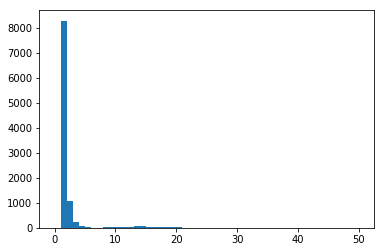

In [13]:
plot_kmer_hist(seqs)

In [14]:
import networkx as nx

If there is no repetitive k-mer, then the de Bruijn Graph is a simple non-branch path. If there are some repetitive k-mers, then ther will be some loops.

In [15]:
G = nx.DiGraph()

for i in range(len(seq)-kmer_size):
    n1 = "".join(seq[i:i+kmer_size])
    n2 = "".join(seq[i+1:i+kmer_size+1])
    G.add_edge(n1, n2)
    

nx.drawing.nx_agraph.write_dot(G, "DBG1.dot")
os.system("dot -Tsvg  -Grankdir=LR  -Nlabel="" -Gsize=120,20 -oDBG1.svg DBG1.dot")
SVG("DBG1.svg")

Becuase the erroneous k-mers, the de Bruijn Graph from the simulated short noisy fragments are complicated and hard to find the represented path that is corresponding to the original template sequence.

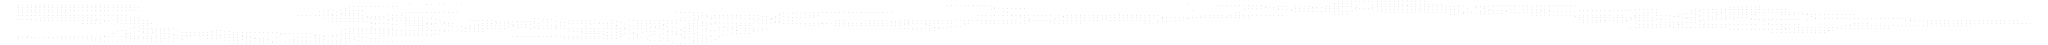

In [16]:

G = nx.DiGraph()
for s in seqs[:100]:
    for i in range(len(s)-kmer_size):
        n1 = s[i:i+kmer_size]
        n2 = s[i+1:i+kmer_size+1]
        G.add_edge(n1, n2)
import os
nx.drawing.nx_agraph.write_dot(G, "DBG2.dot")
os.system("dot -Tsvg  -Grankdir=LR -Nlabel="" -Gsize=60,10 -oDBG2.svg DBG2.dot")
SVG("DBG2.svg")


Convert the simulated noisy fragments to training tensors.

In [17]:
def get_training_set(seqs, k=8):
    in_ = []
    out_ = []
    tmp = []
    for s in seqs:
        for i in range(len(s)-kmer_size-1):
            tmp.append( ([one_hot(c) for c in s[i:i+kmer_size]], [one_hot(c) for c in s[i+kmer_size]]) )
    random.shuffle(tmp)
    in_, out_ = zip(*tmp)
    in_ = Variable(torch.FloatTensor(np.array(in_))).cuda()
    out_ = Variable(torch.FloatTensor(np.array(out_))).cuda()
    return in_, out_

In [18]:
training_in, training_out = get_training_set(seqs,k=kmer_size)

Initialize the Neural DBG.

In [19]:

nDBG = NeuralDBG(kmer_size, 64, 32, 24)
nDBG.cuda()
nDBG.zero_grad()

# initial the paramerters in the DCNet
for name, param in nDBG.named_parameters():
    if 'bias' in name:
        nn.init.constant(param, 0.0)
    elif 'weight' in name:
        nn.init.xavier_normal(param)

Set up the loss function and SGD optimizer.

In [20]:
#loss_function = nn.L1Loss()
loss_function = nn.MSELoss()
lr = 0.1
optimizer = optim.SGD(nDBG.parameters(), lr=lr)

Training the network to predict the k+1 base from the noisy k-mer set.

epoch: 1 loss: 0.00039232322573661807 learning rate: 0.1
epoch: 201 loss: 0.0002718711495399475 learning rate: 0.098
epoch: 401 loss: 0.00022145232558250428 learning rate: 0.09604
epoch: 601 loss: 0.00020507365465164185 learning rate: 0.0941192
epoch: 801 loss: 0.00019205370545387267 learning rate: 0.092236816
epoch: 1001 loss: 0.00017808549106121063 learning rate: 0.09039207968
epoch: 1201 loss: 0.00018718360364437103 learning rate: 0.0885842380864
epoch: 1401 loss: 0.0002112606018781662 learning rate: 0.086812553324672
epoch: 1601 loss: 0.00018236370384693145 learning rate: 0.08507630225817855
epoch: 1801 loss: 0.00016984452307224274 learning rate: 0.08337477621301498
epoch: 2001 loss: 0.00017806638777256013 learning rate: 0.08170728068875467


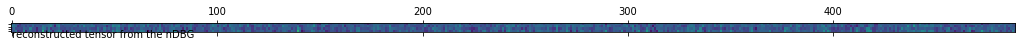

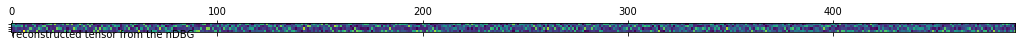

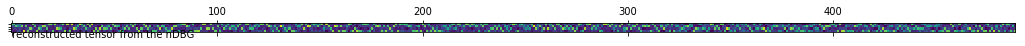

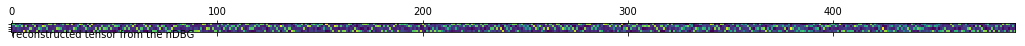

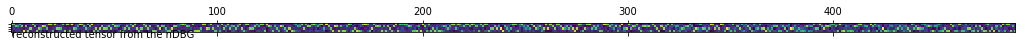

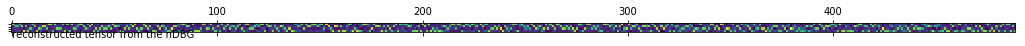

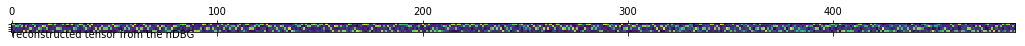

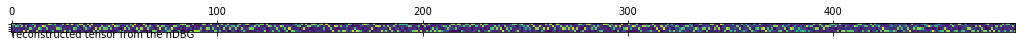

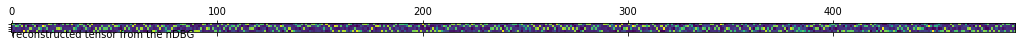

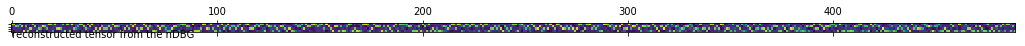

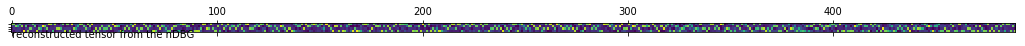

In [21]:
batch_size = 500
for epoch in range(2001):
    for i in range(int(len(training_in)/batch_size)):
        rs = random.randint(0, len(training_in)-batch_size)
        in_ = training_in[rs:rs+batch_size]
        out_ = training_out[rs:rs+batch_size]
        nDBG.zero_grad()
        out = nDBG(in_)
        loss = loss_function(out.view(-1), out_.view(-1))
        loss.backward()
        optimizer.step()
    if epoch % 200 == 0:
        print("epoch:", epoch+1, "loss:", loss.cpu().data[0]/batch_size, "learning rate:", lr)
        lr *= 0.98
        optimizer = optim.SGD(nDBG.parameters(), lr=lr)
        plt.figure(figsize=(18,3))
        seq_out = nDBG(seq_in_)
        xx2 = seq_out.view(-1,4).cpu().data.numpy().transpose()
        plt.matshow(xx2, vmin=-0.1, vmax=1.1, fignum=False)
        plt.text(0,6,"reconstructed tensor from the nDBG")
        frame = plt.gca()
        frame.axes.yaxis.set_ticklabels([]);

Just check if the Neural DBG network can predict correct (k+1)th bases if we send error-free k-mers as the input of the network.

(50, 150)

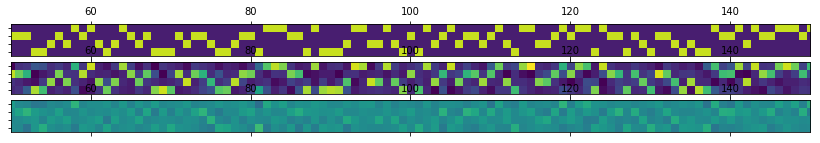

In [22]:

xx1 = seq_out_.view(-1,4).cpu().data.numpy().transpose()
plt.figure(figsize=(18,2))
plt.subplot(3,1,1)
plt.matshow(xx1, vmin=-0.1, vmax=1.1, fignum=False)
#plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])
plt.xlim(50,150)

seq_out = nDBG(seq_in_)
xx2 = seq_out.view(-1,4).cpu().data.numpy().transpose()
plt.subplot(3,1,2)
plt.matshow(xx2, vmin=-0.1, vmax=1.1, fignum=False)
#plt.text(0,6,"reconstructed tensor from the nDBG")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);
plt.xlim(50,150)

plt.subplot(3,1,3)
plt.matshow(xx1-xx2, vmin=-1.1, vmax=1.1, fignum=False)
#plt.text(0,6,"differences");
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);
plt.xlim(50,150)

Just plot the residue errors.

(-1, 1)

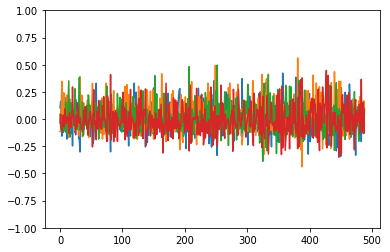

In [23]:
plt.plot(xx1.transpose()-xx2.transpose());
plt.ylim(-1,1)

Just re-construct the sequence with neural dBG network. We take the first k-mer of the template and construct the sequence using just the trained neural dBG network 

In [24]:
index2base = dict(zip([0,1,2,3],"ACGT"))
new_seq=[]
for x in seq_in_[0:1].view(-1, kmer_size,4)[0]:
    idx = np.argmax(x.view(-1,4).cpu().data.numpy()[0])
    base = index2base[idx]
    new_seq.append(base)
out_all = []
for i in range(len(seq)-kmer_size):
    tmp_in_ = [one_hot(c) for c in new_seq[-kmer_size:]]
    tmp_in = Variable(torch.FloatTensor(np.array(tmp_in_))).cuda()
    tmp_out = nDBG(tmp_in)
    out_all.append(tmp_out.view(-1,4).cpu().data.numpy()[0])
    idx=np.argmax(tmp_out.view(-1,4).cpu().data.numpy()[0])
    base = index2base[idx]
    new_seq.append(base)
print("".join(new_seq))
print("".join(seq))

AAGCCCAATAAACCACTCTGACTGGCCGAATAGGGATATAGGCAACGACATGTGCGGCGACCCTTGCGACAGTGACGCTTTCGCCGTTGCCTAAACCTATTTGAAGGAGTCTAGCAGCCGCAGTAAGGCACAATACCTCGTCCGTGTTACCAGACCAAACAAGACGTCCTCTTCAATGTTTAAATGACCCTCTCGTCATAAAACCTTTCTACTATGTGTTCCGCAAGAATCAACAACTACAATGGCGCGTCGTGAATAACGCGACGGCTGAGACGAACGGCGCGTGAATGAAGCGCTTAAACAGCTCAGGAGCCAGTCCCCTACGTCGCATATCCTGGCCACTGGAGGTGAAGCGAATGGTATCGATACGTAGGAGGTGTGCCTTCGTAGGCTGTTTCTCAGGACGCCCAACTATTCTTTCCAATCCTACATCTGTTTCTTGCGTCGTAGCGGGACCCTCCATTGTTACTTATTAGGTTCTCGTTATGTCTCATAATCTG
AAGCCCAATAAACCACTCTGACTGGCCGAATAGGGATATAGGCAACGACATGTGCGGCGACCCTTGCGACAGTGACGCTTTCGCCGTTGCCTAAACCTATTTGAAGGAGTCTAGCAGCCGCAGTAAGGCACAATACCTCGTCCGTGTTACCAGACCAAACAAGACGTCCTCTTCAATGTTTAAATGACCCTCTCGTCATAAAACCTTTCTACTATGTGTTCCGCAAGAATCAACAACTACAATGGCGCGTCGTGAATAACGCGACGGCTGAGACGAACGGCGCGTGAATGAAGCGCTTAAACAGCTCAGGAGCCAGTCCCCTACGTCGCATATCCTGGCCACTGGAGGTGAAGCGAATGGTATCGATACGTAGGAGGTGTGCCTTCGTAGGCTGTTTCTCAGGACGCCCAACTATTCTTTCCAATCCTACATCTGTTTCTTGCGTCGTAGCGGGACCCTCCATTGTTACTTATTAGGTTCTCGTTATGTCTCATAATCT

Let's make a quick dot plot to compare the reconstruct sequences and the original sequence.

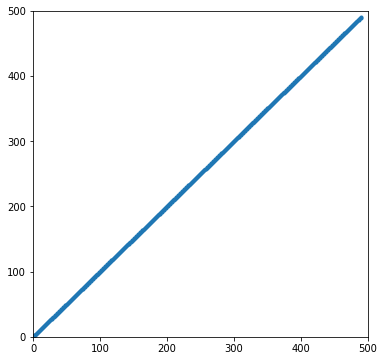

In [25]:
quick_dot("".join(new_seq),"".join(seq), k=9)

--
Apr. 15, 2018, Jason Chin